In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print ("Device: ", DEVICE)
MODEL_NAME = "Qwen/Qwen2.5-0.5B" # We need to use a rope model here as per paper
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    output_attentions=True,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
).to(DEVICE)
model.eval()


Device:  cuda


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2

In [16]:
text = """
When I first learnt about Transformers and LLMs, batching felt extremely intuitive. We just stack the inputs, push them through GPUs, and let massive parallel compute take care of latency and throughput. Bigger batches make the training faster with good GPU utilization.
But when I tried to implement that logic to an LLM inference engine for a low-power edge device, that intuition hit a wall. The latency didn’t just climb; it spiked. GPU utilization looked “fine” on the dashboard, but the end-to-end performance was painfully slow. At first, I figured I just sucked at implementing it. I spent days throwing every optimization in the book at the problem: batching, KV caching, quantization, custom kernels assuming I’d eventually find the bottleneck. But the performance didn’t budge. That’s when it hit me: I wasn’t fighting bad code; I was fighting the architecture itself. Let me try to explain why and how everything breaks at Inference:
Training batching is a static tensor problem
In simple words, batching during training works because everything is known before computation. We have a batch of sequences, usually padded to a fixed length. Every token in every sequence is processed simultaneously. The transformer forward pass is a sequence of linear algebra operations (mostly matrix multiplications and softmaxes), all operating on tensors with fixed shapes. Mathematically, training is a single static program:
where B is the batch size, T the sequence length, and d the model dimension. The GPU sees a predictable workload and memory access patterns are regular. Nothing depends on runtime decisions.
An H100 can sustain ~60 TFLOPs of FP16 compute, but more importantly ,training kernels exhibit high arithmetic intensity, with dozens of FLOPs performed per byte loaded from memory. As a result, training workloads remain compute-bound, which is exactly what GPUs are designed for.
Inference changes this problem class. Inference for LLMs is autoregressive which simply means; tokens are generated one at a time and each new token depends on all the previous tokens:
There is no way for us to parallelize this across a time step. For every batch, all sequences must wait for the slowest one at every step. To make things much worse, inference in real-life is even messier when requests keep arriving continuously, prompts length vary a lot, some users want a “yes/no” and some want to expand their 10 line essays to 1000 words :)
"""

inputs = tokenizer(text, return_tensors="pt").to(DEVICE)


In [17]:
LAYER_IDX = 10
HEAD_IDX = 0

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[LAYER_IDX]

# Full attention scores for one head
full_attn = attn[0, HEAD_IDX].float()
T = full_attn.shape[0]


In [18]:
def topk_indices(x, k):
    return torch.topk(x, k).indices.cpu().numpy()

def contextual_agreement(full_scores, fc_scores, k):
    a = set(topk_indices(full_scores, k))
    b = set(topk_indices(fc_scores, k))
    return len(a & b) / k

def compute_ca_per_fc(q, k, full_scores, topk=64):
    """
    q: [d]
    k: [T, d]
    """
    d = q.shape[0]
    num_fc = d // 2
    ca = []

    for i in range(num_fc):
        idx = [2*i, 2*i + 1]
        qi = q[idx]
        ki = k[:, idx]
        scores_i = (qi.unsqueeze(0) * ki).sum(dim=-1)
        ca.append(contextual_agreement(full_scores, scores_i, topk))

    return np.array(ca)


In [19]:
with torch.no_grad():
    hidden_states = model.model(inputs.input_ids).last_hidden_state[0]

attn_module = model.model.layers[LAYER_IDX].self_attn
Wq, Wk = attn_module.q_proj, attn_module.k_proj

q = Wq(hidden_states[-1])  # last token query
k = Wk(hidden_states)      # all keys
num_q_heads = model.config.num_attention_heads
num_kv_heads = model.config.num_key_value_heads
head_dim = model.config.hidden_size // num_q_heads

q = q.view(num_q_heads, head_dim)[HEAD_IDX]
k = k.view(T, num_kv_heads, head_dim)

kv_head_idx = HEAD_IDX % num_kv_heads
k = k[:, kv_head_idx]



In [20]:
TOPK = 64
ca_scores = compute_ca_per_fc(
    q.float(),
    k.float(),
    full_attn[-1],   # attention of only last token
    topk=TOPK
)


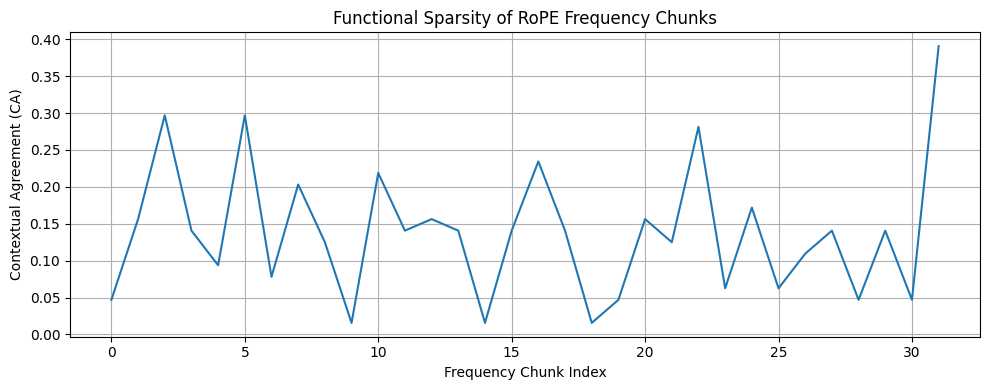

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(ca_scores)
plt.xlabel("Frequency Chunk Index")
plt.ylabel("Contextual Agreement (CA)")
plt.title("Functional Sparsity of RoPE Frequency Chunks")
plt.grid(True)
plt.tight_layout()
plt.savefig("ca_vs_fc.png")
plt.show()


In [22]:
F = 8
dominant_fcs = np.argsort(ca_scores)[-F:]
random_fcs = np.random.choice(len(ca_scores), F, replace=False)

In [23]:
def attention_from_fcs(q, k, fc_indices):
    scores = torch.zeros(
        k.shape[0],
        device=q.device,
        dtype=q.dtype
    )
    for i in fc_indices:
        i = int(i)
        idx = [2*i, 2*i + 1]
        scores += (q[idx].unsqueeze(0) * k[:, idx]).sum(dim=-1)
    return scores

In [24]:
print("q device:", q.device)
print("k device:", k.device)

q device: cuda:0
k device: cuda:0


In [25]:
dominant_fcs = [int(i) for i in dominant_fcs]
random_fcs   = [int(i) for i in random_fcs]

full_scores = full_attn[-1]
dom_scores  = attention_from_fcs(q, k, dominant_fcs)
rand_scores = attention_from_fcs(q, k, random_fcs)

full_scores = full_scores.cpu()
dom_scores  = dom_scores.cpu()
rand_scores = rand_scores.cpu()


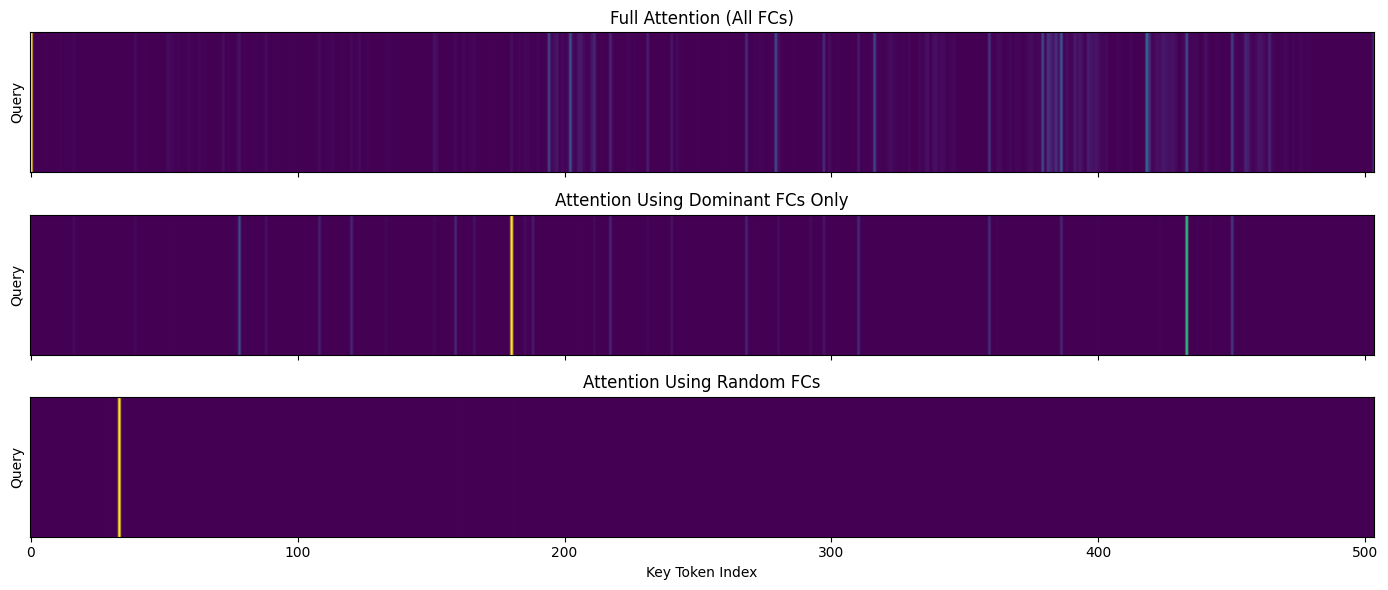

In [26]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

full_scores = full_scores.detach().cpu()
dom_scores  = dom_scores.detach().cpu()
rand_scores = rand_scores.detach().cpu()

def normalize(x):
    return F.softmax(x / (x.numel() ** 0.5), dim=-1)

full_scores_n = normalize(full_scores)
dom_scores_n  = normalize(dom_scores)
rand_scores_n = normalize(rand_scores)

fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

axes[0].imshow(
    full_scores_n.unsqueeze(0),
    aspect="auto",
    cmap="viridis"
)
axes[0].set_title("Full Attention (All FCs)")

axes[1].imshow(
    dom_scores_n.unsqueeze(0),
    aspect="auto",
    cmap="viridis"
)
axes[1].set_title("Attention Using Dominant FCs Only")

axes[2].imshow(
    rand_scores_n.unsqueeze(0),
    aspect="auto",
    cmap="viridis"
)
axes[2].set_title("Attention Using Random FCs")

for ax in axes:
    ax.set_yticks([])
    ax.set_ylabel("Query")

axes[-1].set_xlabel("Key Token Index")

plt.tight_layout()
plt.savefig("attention_fc_heatmaps.png", dpi=200)
plt.show()


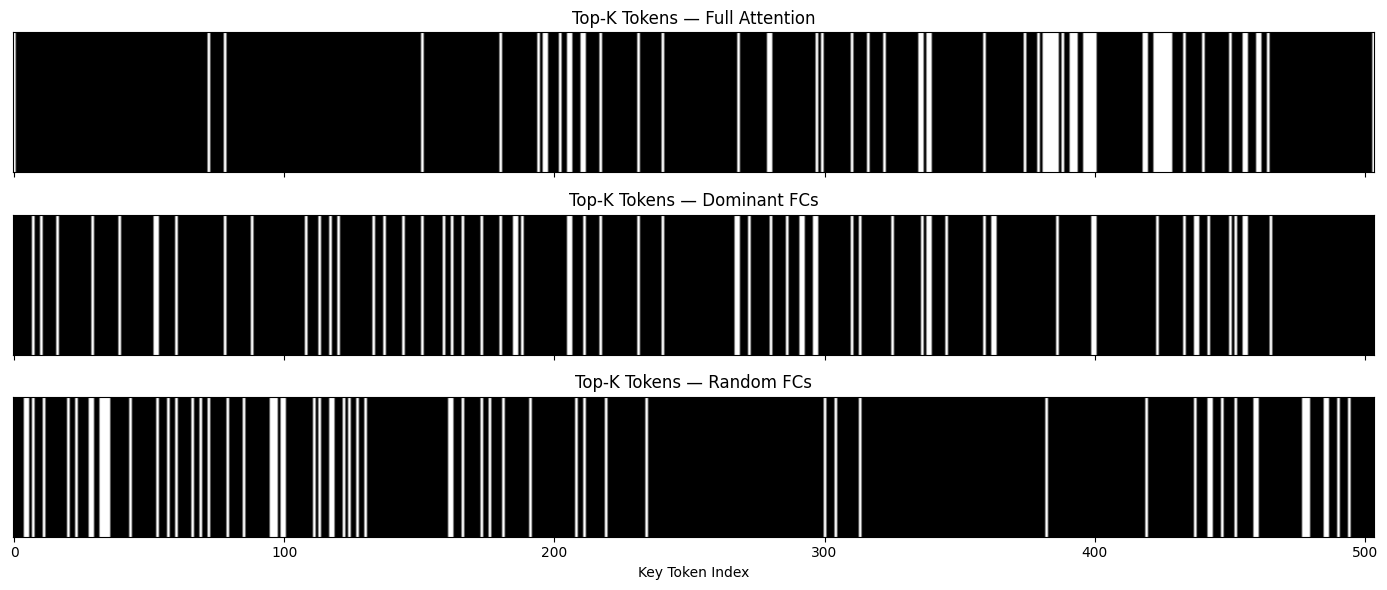

In [27]:
def softmax_scores(x):
    return F.softmax(x / (x.numel() ** 0.5), dim=-1)

full_attn_vis = softmax_scores(full_scores)
dom_attn_vis  = softmax_scores(dom_scores)
rand_attn_vis = softmax_scores(rand_scores)
def topk_mask(x, k=64):
    mask = torch.zeros_like(x)
    idx = torch.topk(x, k).indices
    mask[idx] = 1.0
    return mask

full_mask = topk_mask(full_attn_vis)
dom_mask  = topk_mask(dom_attn_vis)
rand_mask = topk_mask(rand_attn_vis)
fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

axes[0].imshow(full_mask.unsqueeze(0), aspect="auto", cmap="gray")
axes[0].set_title("Top-K Tokens — Full Attention")

axes[1].imshow(dom_mask.unsqueeze(0), aspect="auto", cmap="gray")
axes[1].set_title("Top-K Tokens — Dominant FCs")

axes[2].imshow(rand_mask.unsqueeze(0), aspect="auto", cmap="gray")
axes[2].set_title("Top-K Tokens — Random FCs")

for ax in axes:
    ax.set_yticks([])

axes[-1].set_xlabel("Key Token Index")
plt.tight_layout()
plt.show()


In [28]:
def recall_at_k(full_scores, approx_scores, k=64):
    full_topk = set(torch.topk(full_scores, k).indices.tolist())
    approx_topk = set(torch.topk(approx_scores, k).indices.tolist())
    return len(full_topk & approx_topk) / k

print("Recall@K (Dominant FCs):",
      recall_at_k(full_scores, dom_scores, k=64))

print("Recall@K (Random FCs):",
      recall_at_k(full_scores, rand_scores, k=64))


Recall@K (Dominant FCs): 0.390625
Recall@K (Random FCs): 0.078125
